In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Again asking the question, are clinvar variants that are in amino acids that are near glycosites more likely to be pathogenic than ones that are not, but now with continuous values

In [13]:
path_dct = {'benign':1,
            'likely benign':2,
            'likely pathogenic':3,
            'pathogenic':4}

In [51]:
df = pd.read_csv('../data/clinvar_glycoproteins_distances.txt',
                 sep='\t',
                index_col=0)
df = df.sort_values(by='clinvar_path')
df['clinvar_path_val'] = [path_dct[c] for c in df['clinvar_path']]
df['log_distance'] = np.log10(df['distance_to_feature'])

Text(0,0.5,'log(distance to N-Gly)')

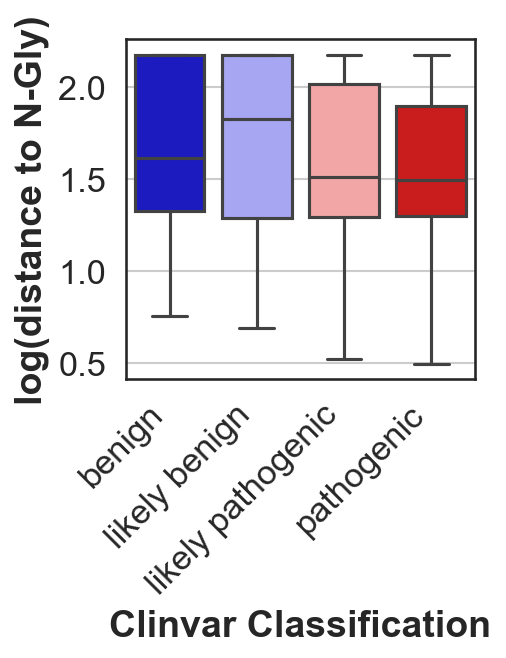

In [52]:
sns.set_context("paper")
    
# Set the font to be serif, rather than sans
sns.set(font='arial',font_scale=1.5)

# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "arial",'axes.grid': True,"font.size":14,"axes.labelsize":14})

plt.figure(dpi=150,figsize=(3,3))
df = df.sort_values(by='clinvar_path')
sns.boxplot(x='clinvar_path',
            y='log_distance',
            data=df,
            palette='seismic',)
plt.xlabel('Clinvar Classification',fontweight='bold')
plt.xticks(rotation='45',ha='right')
plt.ylabel('log(distance to N-Gly)',fontweight='bold')

In [44]:
formula = 'clinvar_path_val ~ distance_to_feature'

model = smf.ols(formula=formula, data=df).fit()

In [45]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       clinvar_path_val   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     70.83
Date:                Wed, 04 Mar 2020   Prob (F-statistic):           5.01e-17
Time:                        17:02:31   Log-Likelihood:                -6764.8
No. Observations:                5018   AIC:                         1.353e+04
Df Residuals:                    5016   BIC:                         1.355e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.6045      0.020    183.145      0.000       3.566       3.643
distance_to_feature    -0.0020      0.000     -8.416      0.000      -0.003      -0.002
==============================================================================
Omnibus:                     1389.720   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2894.258
Skew:                          -1.678   Prob(JB):                         0.00
Kurtosis:                       4.605   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Looking at relationships on a per amino acid change level

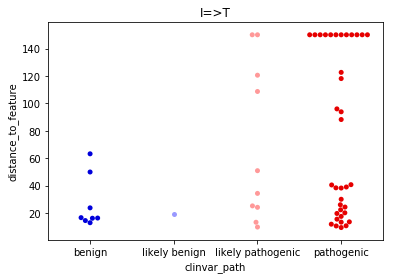

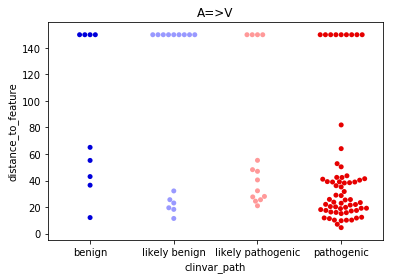

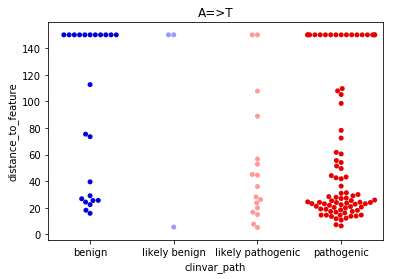

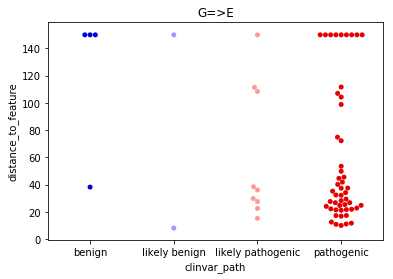

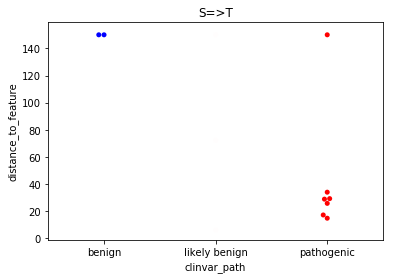

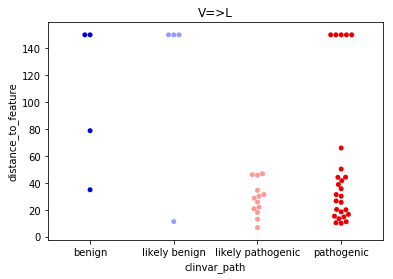

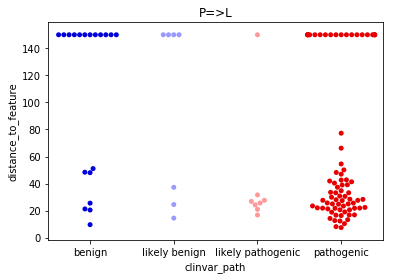

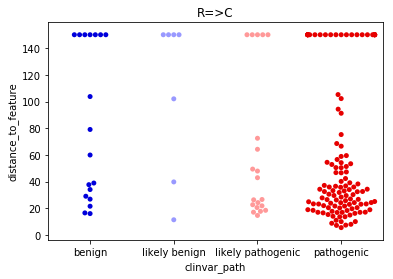

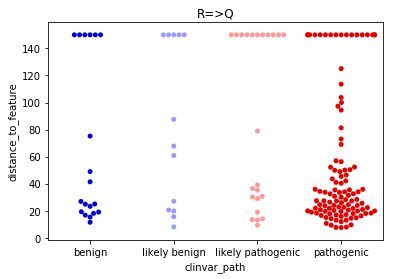

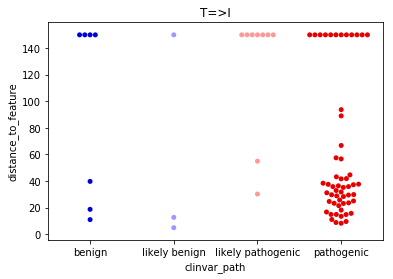

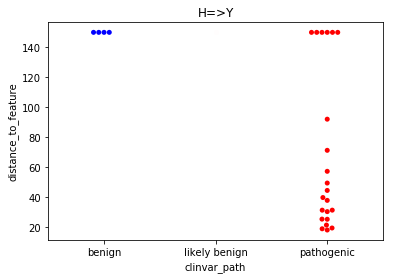

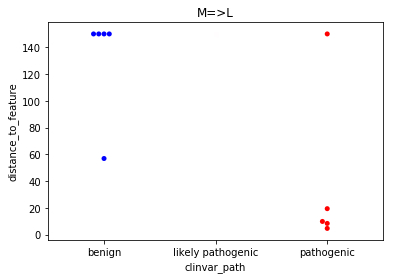

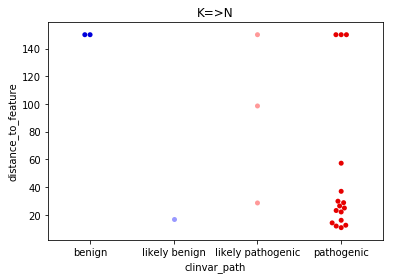

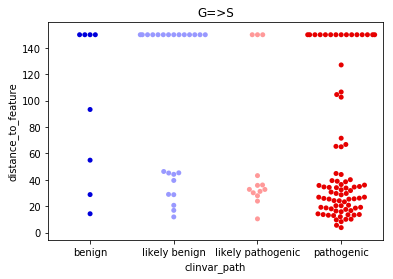

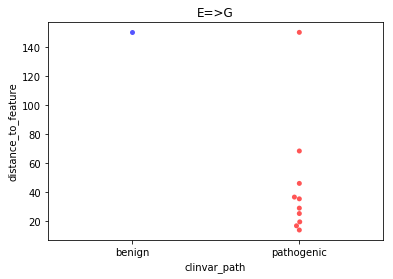

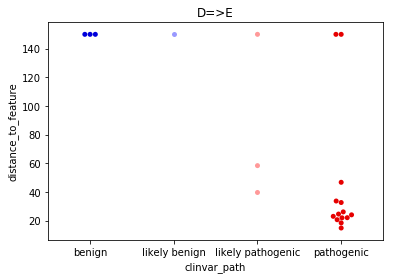

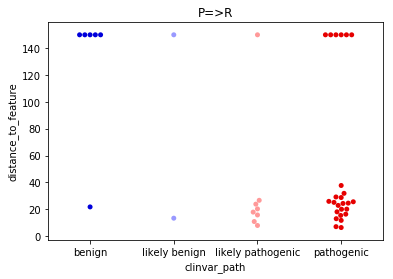

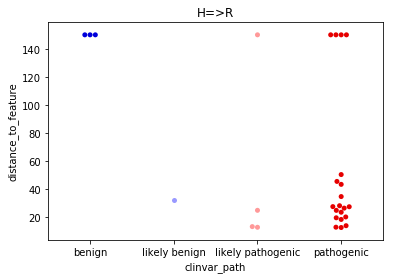

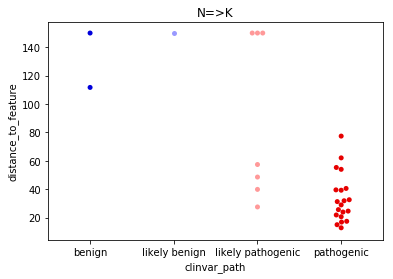

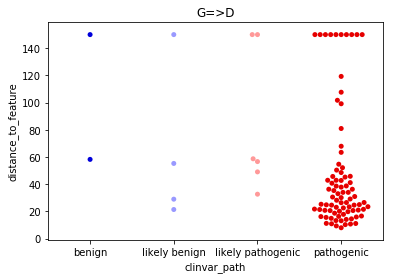

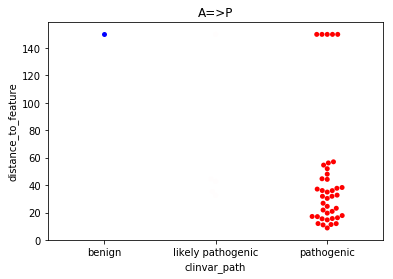

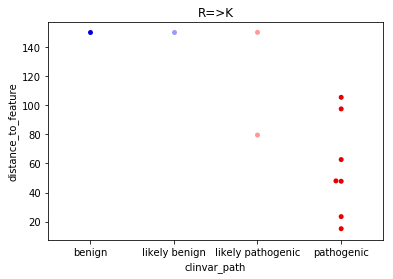

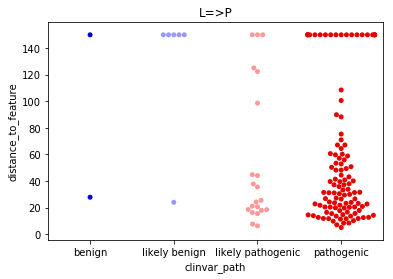

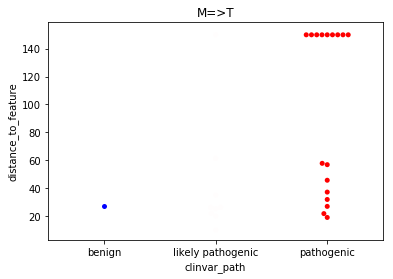

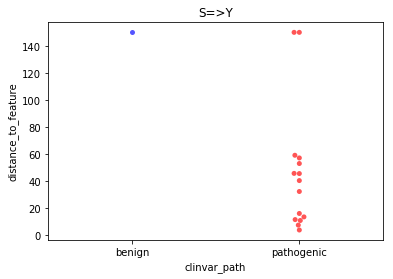

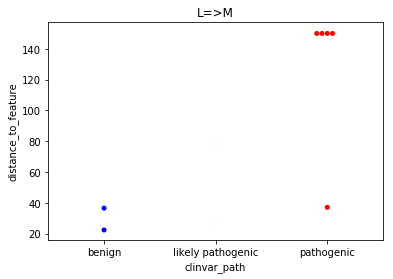

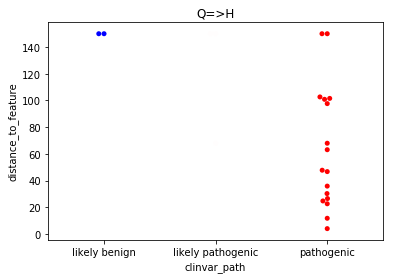

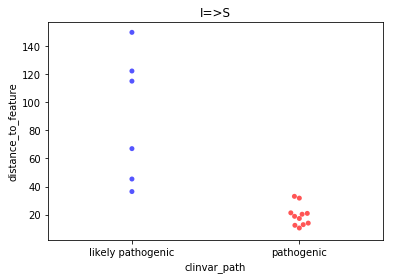

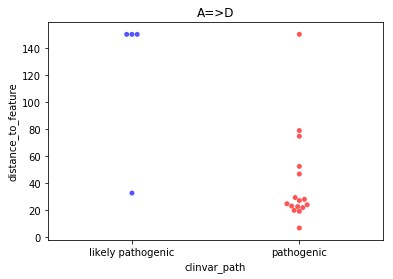

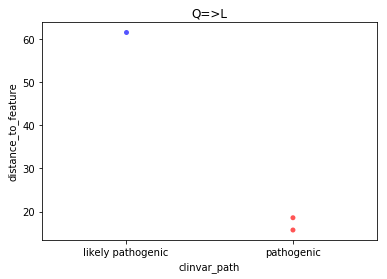

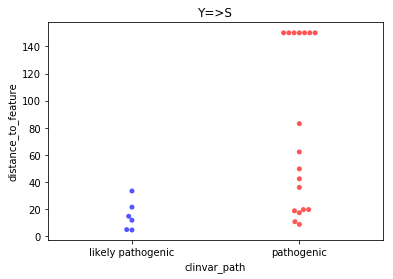

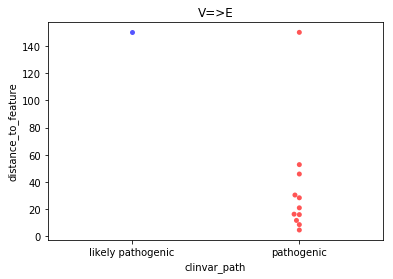

In [18]:
for ac in df['aa_change'].unique():
    aa_df = df[df['aa_change'] == ac]
    
    if aa_df.shape[0] < 3 or len(aa_df['clinvar_path'].unique()) < 2:
        continue
        
    formula = 'clinvar_path_val ~ distance_to_feature'

    model = smf.ols(formula=formula, data=aa_df).fit()  
    p = model.pvalues['distance_to_feature']
    
    if p < 0.05:
        
        sns.swarmplot(x='clinvar_path',
                        y='distance_to_feature',
                        data=aa_df,
                        palette='seismic',)

        plt.title(ac)
        plt.show()

## Looking on a per class basis

In [56]:
aa_class = pd.read_csv('../data/glyco_protein_impact_within_6.csv')

In [66]:
high_glyco_neg_prot = aa_class[aa_class['glyco_impact'].isin(['high','medium']) & (aa_class['proteinStruct_impact'] == 'negligable - frequent')]
high_glyco_neg_prot

,substitution,glyco_distance,Blosum64,glyco_impact,proteinStruct_impact
15,A=>V,25.950160,0,medium,negligable - frequent
43,D=>Q,28.903581,0,medium,negligable - frequent
66,F=>W,33.752997,1,high,negligable - frequent
67,F=>Y,33.526628,3,high,negligable - frequent
91,I=>F,33.608746,0,high,negligable - frequent
98,I=>V,24.800146,3,medium,negligable - frequent
109,L=>F,33.819905,0,high,negligable - frequent
115,L=>V,25.122326,1,medium,negligable - frequent
118,M=>F,33.549813,0,high,negligable - frequent
122,M=>V,24.747438,1,medium,negligable - frequent


In [67]:
low_glyco_neg_prot = aa_class[aa_class['glyco_impact'].isin(['low']) & (aa_class['proteinStruct_impact'] == 'negligable - frequent')]
low_glyco_neg_prot

,substitution,glyco_distance,Blosum64,glyco_impact,proteinStruct_impact
0,A=>C,9.051015,0,low,negligable - frequent
4,A=>G,7.815168,0,low,negligable - frequent
13,A=>S,11.126291,1,low,negligable - frequent
14,A=>T,14.766297,0,low,negligable - frequent
34,D=>E,6.918130,2,low,negligable - frequent
44,D=>S,3.538718,0,low,negligable - frequent
51,E=>H,7.444015,0,low,negligable - frequent
53,E=>K,11.851892,1,low,negligable - frequent
57,E=>S,8.799551,0,low,negligable - frequent
75,G=>S,3.531126,0,low,negligable - frequent


7.132843284373504e-05


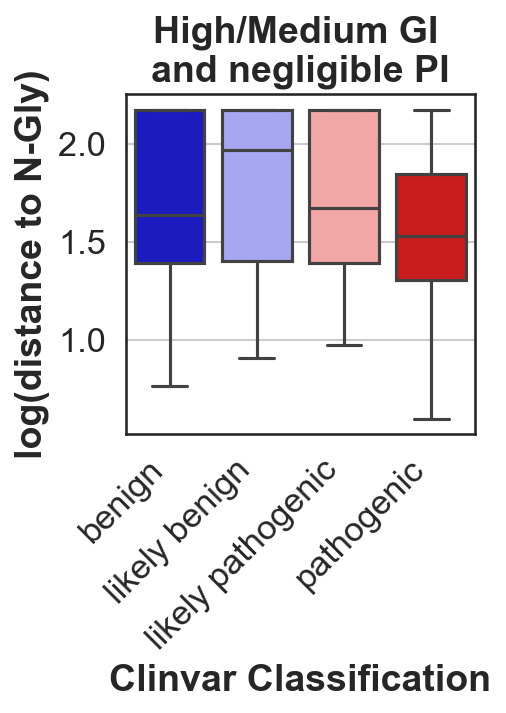

2.1457326364892913e-05


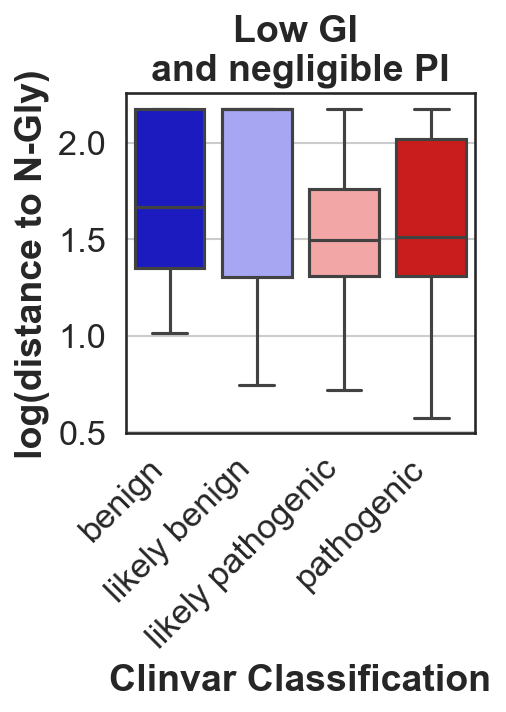

In [77]:
classifications = [(high_glyco_neg_prot,'High/Medium GI \nand negligible PI'),
                   (low_glyco_neg_prot,'Low GI \nand negligible PI')]

for aa_classes in classifications:
    
    aa_class,label = aa_classes
    
    aas = aa_class['substitution']
    aa_df = df[df['aa_change'].isin(aas)]
    
    if aa_df.shape[0] < 3 or len(aa_df['clinvar_path'].unique()) < 2:
        continue
        
    formula = 'clinvar_path_val ~ distance_to_feature'

    model = smf.ols(formula=formula, data=aa_df).fit()  
    p = model.pvalues['distance_to_feature']
    print(p)
    plt.figure(dpi=150,figsize=(3,3))
    sns.boxplot(x='clinvar_path',
                    y='log_distance',
                    data=aa_df,
                    palette='seismic',)

    plt.title(label,fontweight='bold')
    plt.xlabel('Clinvar Classification',fontweight='bold')
    plt.xticks(rotation='45',ha='right')
    plt.ylabel('log(distance to N-Gly)',fontweight='bold')
    plt.show()